For an end-to-end walkthrough of training a Gradient Boosting model check out the boosted trees tutorial. In this tutorial you will:

Learn how to interpret a Boosted Tree model both locally and globally
Gain intution for how a Boosted Trees model fits a dataset
How to interpret Boosted Trees models both locally and globally
Local interpretability refers to an understanding of a model’s predictions at the individual example level, while global interpretability refers to an understanding of the model as a whole. Such techniques can help machine learning (ML) practitioners detect bias and bugs during the model development stage

For local interpretability, you will learn how to create and visualize per-instance contributions. To distinguish this from feature importances, we refer to these values as directional feature contributions (DFCs).

For global interpretability you will retrieve and visualize gain-based feature importances, permutation feature importances and also show aggregated DFCs.

In [1]:
from __future__ import absolute_import, division, print_function

import numpy as np
import pandas as pd
from IPython.display import clear_output

# Load dataset.
dftrain = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv')
dfeval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv')
y_train = dftrain.pop('survived')
y_eval = dfeval.pop('survived')

In [2]:
import tensorflow as tf
tf.random.set_seed(123)

In [3]:
fc = tf.feature_column
CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck', 
                       'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']
  
def one_hot_cat_column(feature_name, vocab):
  return fc.indicator_column(
      fc.categorical_column_with_vocabulary_list(feature_name,
                                                 vocab))
feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
  # Need to one-hot encode categorical features.
  vocabulary = dftrain[feature_name].unique()
  feature_columns.append(one_hot_cat_column(feature_name, vocabulary))
  
for feature_name in NUMERIC_COLUMNS:
  feature_columns.append(fc.numeric_column(feature_name,
                                           dtype=tf.float32))

In [4]:
# Use entire batch since this is such a small dataset.
NUM_EXAMPLES = len(y_train)

def make_input_fn(X, y, n_epochs=None, shuffle=True):
  def input_fn():
    dataset = tf.data.Dataset.from_tensor_slices((X.to_dict(orient='list'), y))
    if shuffle:
      dataset = dataset.shuffle(NUM_EXAMPLES)
    # For training, cycle thru dataset as many times as need (n_epochs=None).    
    dataset = (dataset
      .repeat(n_epochs)
      .batch(NUM_EXAMPLES)) 
    return dataset
  return input_fn

# Training and evaluation input functions.
train_input_fn = make_input_fn(dftrain, y_train)
eval_input_fn = make_input_fn(dfeval, y_eval, shuffle=False, n_epochs=1)

In [5]:
params = {
  'n_trees': 50,
  'max_depth': 3,
  'n_batches_per_layer': 1,
  # You must enable center_bias = True to get DFCs. This will force the model to 
  # make an initial prediction before using any features (e.g. use the mean of 
  # the training labels for regression or log odds for classification when
  # using cross entropy loss).
  'center_bias': True
}


In [6]:
est = tf.estimator.BoostedTreesClassifier(feature_columns, **params)

W0320 09:50:39.582047 140381261641536 estimator.py:1799] Using temporary folder as model directory: /tmp/tmpp5igbgyg
W0320 09:50:39.583425 140381261641536 deprecation.py:323] From /home/rohan/miniconda3/envs/deep_learning_tf/lib/python3.6/site-packages/tensorflow_estimator/python/estimator/canned/boosted_trees.py:296: VocabularyListCategoricalColumn._num_buckets (from tensorflow.python.feature_column.feature_column_v2) is deprecated and will be removed in a future version.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.


In [9]:
# Train model 
est.train(train_input_fn, max_steps=10)

W0320 09:50:59.674740 140381261641536 deprecation.py:323] From /home/rohan/miniconda3/envs/deep_learning_tf/lib/python3.6/site-packages/tensorflow/python/training/saver.py:1069: get_checkpoint_mtimes (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file utilities to get mtimes.
W0320 09:50:59.954474 140381261641536 meta_graph.py:447] Issue encountered when serializing resources.
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'_Resource' object has no attribute 'name'
W0320 09:51:00.055233 140381261641536 meta_graph.py:447] Issue encountered when serializing resources.
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'_Resource' object has no attribute 'name'
W0320 09:51:00.573631 140381261641536 meta_grap

In [10]:
# Evaluation.
results = est.evaluate(eval_input_fn)
clear_output()
pd.Series(results).to_frame()

,0
accuracy,0.776515
accuracy_baseline,0.625000
auc,0.826477
auc_precision_recall,0.803011
average_loss,0.527235
label/mean,0.375000
loss,0.527235
precision,0.732558
prediction/mean,0.387740
recall,0.636364


### Local interpretability
Next you will output the directional feature contributions (DFCs) to explain individual predictions using the approach outlined in Palczewska et al and by Saabas in Interpreting Random Forests (this method is also available in scikit-learn for Random Forests in the treeinterpreter package). The DFCs are generated with:

` pred_dicts = list(est.experimental_predict_with_explanations(pred_input_fn)) `



In [11]:
## Model interpretation and plotting 
import matplotlib.pyplot as plt 
import seaborn as sns
sns_colors = sns.color_palette('colorblind')

In [12]:
pred_dict = list(est.experimental_predict_with_explanations(eval_input_fn))

In [13]:
# Create DFC Pandas dataframe 
labels = y_eval.values
probs = pd.Series([pred['probabilities'][1] for pred in pred_dict])
df_dfc = pd.DataFrame([pred['dfc'] for pred in pred_dict])
df_dfc.describe().T

,count,mean,std,min,25%,50%,75%,max
sex,264.0,0.003308,0.065369,-0.050402,-0.045793,-0.045793,0.088463,0.089838
age,264.0,-0.018243,0.023023,-0.039712,-0.039712,-0.021934,0.000000,0.080979
deck,264.0,-0.012006,0.012086,-0.023416,-0.023416,-0.023416,0.000000,0.003042
class,264.0,0.010979,0.039697,-0.020840,-0.018049,-0.018049,0.021033,0.090884
alone,264.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
embark_town,264.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
fare,264.0,0.016141,0.035242,-0.070728,0.000000,0.000000,0.033060,0.088988
n_siblings_spouses,264.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
parch,264.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [14]:
# Sum of the DFC + bais = Probability
bias = pred_dict[0]['bias']
dfc_prob = df_dfc.sum(axis=1) + bias 
np.testing.assert_almost_equal(dfc_prob.values, probs.values)

In [15]:
# Boilerplate code for plotting :)
def _get_color(value):
    """To make positive DFCs plot green, negative DFCs plot red."""
    green, red = sns.color_palette()[2:4]
    if value >= 0: return green
    return red

def _add_feature_values(feature_values, ax):
    """Display feature's values on left of plot."""
    x_coord = ax.get_xlim()[0]
    OFFSET = 0.15
    for y_coord, (feat_name, feat_val) in enumerate(feature_values.items()):
        t = plt.text(x_coord, y_coord - OFFSET, '{}'.format(feat_val), size=12)
        t.set_bbox(dict(facecolor='white', alpha=0.5))
    from matplotlib.font_manager import FontProperties
    font = FontProperties()
    font.set_weight('bold')
    t = plt.text(x_coord, y_coord + 1 - OFFSET, 'feature\nvalue',
    fontproperties=font, size=12)
    
def plot_example(example):
  TOP_N = 8 # View top 8 features.
  sorted_ix = example.abs().sort_values()[-TOP_N:].index  # Sort by magnitude.
  example = example[sorted_ix]
  colors = example.map(_get_color).tolist()
  ax = example.to_frame().plot(kind='barh',
                          color=[colors],
                          legend=None,
                          alpha=0.75,
                          figsize=(10,6))
  ax.grid(False, axis='y')
  ax.set_yticklabels(ax.get_yticklabels(), size=14)

  # Add feature values.
  _add_feature_values(dfeval.iloc[ID][sorted_ix], ax)
  return ax

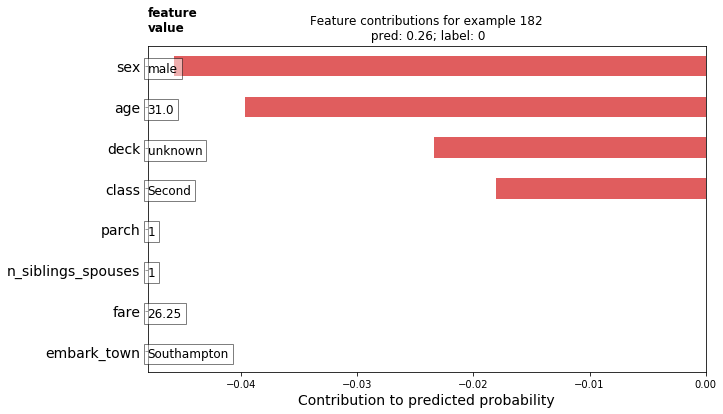

In [16]:
# Plot results.
ID = 182
example = df_dfc.iloc[ID]  # Choose ith example from evaluation set.
TOP_N = 8  # View top 8 features.
sorted_ix = example.abs().sort_values()[-TOP_N:].index
ax = plot_example(example)
ax.set_title('Feature contributions for example {}\n pred: {:1.2f}; label: {}'.format(ID, probs[ID], labels[ID]))
ax.set_xlabel('Contribution to predicted probability', size=14);

In [17]:
# Boilerplate plotting code.
def dist_violin_plot(df_dfc, ID):
  # Initialize plot.
  fig, ax = plt.subplots(1, 1, figsize=(10, 6))
  
  # Create example dataframe.
  TOP_N = 8  # View top 8 features.
  example = df_dfc.iloc[ID]
  ix = example.abs().sort_values()[-TOP_N:].index
  example = example[ix]
  example_df = example.to_frame(name='dfc')
  
  # Add contributions of entire distribution.
  parts=ax.violinplot([df_dfc[w] for w in ix],
                 vert=False,
                 showextrema=False,
                 widths=0.7,
                 positions=np.arange(len(ix)))
  face_color = sns_colors[0]
  alpha = 0.15
  for pc in parts['bodies']:
      pc.set_facecolor(face_color)
      pc.set_alpha(alpha)
  
  # Add feature values.
  _add_feature_values(dfeval.iloc[ID][sorted_ix], ax)

  # Add local contributions.
  ax.scatter(example,
              np.arange(example.shape[0]),
              color=sns.color_palette()[2],
              s=100,
              marker="s",
              label='contributions for example')
  
  # Legend
  # Proxy plot, to show violinplot dist on legend.
  ax.plot([0,0], [1,1], label='eval set contributions\ndistributions',
          color=face_color, alpha=alpha, linewidth=10)
  legend = ax.legend(loc='lower right', shadow=True, fontsize='x-large',
                     frameon=True)
  legend.get_frame().set_facecolor('white')
  
  # Format plot.
  ax.set_yticks(np.arange(example.shape[0]))
  ax.set_yticklabels(example.index)
  ax.grid(False, axis='y')
  ax.set_xlabel('Contribution to predicted probability', size=14)

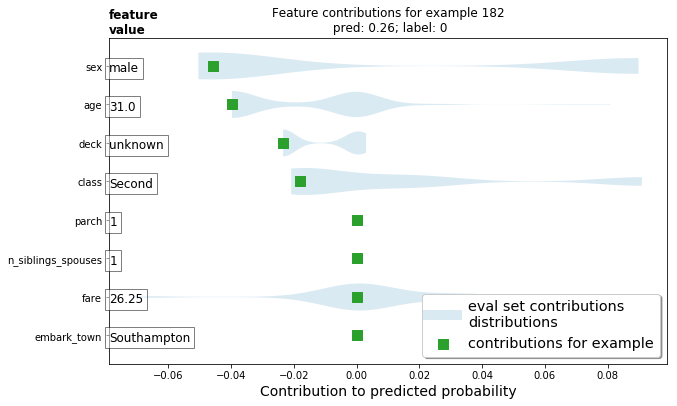

In [18]:
dist_violin_plot(df_dfc, ID)
plt.title('Feature contributions for example {}\n pred: {:1.2f}; label: {}'.format(ID, probs[ID], labels[ID]));

### Global feature importances
Additionally, you might want to understand the model as a whole, rather than studying individual predictions. Below, you will compute and use:

Gain-based feature importances using est.experimental_feature_importances
Permutation importances
Aggregate DFCs using est.experimental_predict_with_explanations
Gain-based feature importances measure the loss change when splitting on a particular feature, while permutation feature importances are computed by evaluating model performance on the evaluation set by shuffling each feature one-by-one and attributing the change in model performance to the shuffled feature.

In general, permutation feature importance are preferred to gain-based feature importance, though both methods can be unreliable in situations where potential predictor variables vary in their scale of measurement or their number of categories and when features are correlated (source). Check out this article for an in-depth overview and great discussion on different feature importance types.

1. Gain-based feature importances
Gain-based feature importances are built into the TensorFlow Boosted Trees estimators using est.experimental_feature_importances.

In [19]:
importantce = est.experimental_feature_importances(normalize=True)
df_imp = pd.Series(importantce)

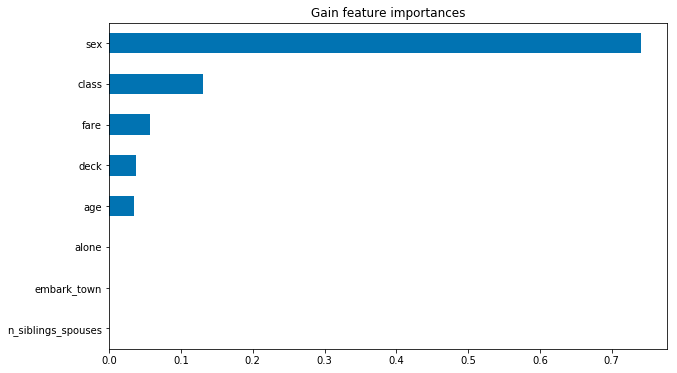

In [20]:
# Visualize importances.
N = 8
ax = (df_imp.iloc[0:N][::-1]
    .plot(kind='barh',
          color=sns_colors[0],
          title='Gain feature importances',
          figsize=(10, 6)))
ax.grid(False, axis='y')

2. Average absolute DFCs
You can also average the absolute values of DFCs to understand impact at a global level.

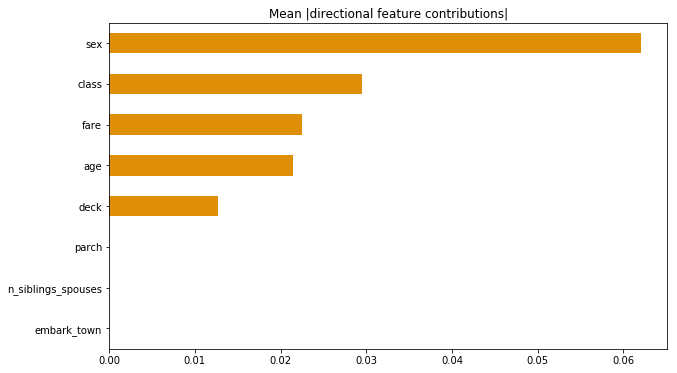

In [22]:
# Plot.
dfc_mean = df_dfc.abs().mean()
N = 8
sorted_ix = dfc_mean.abs().sort_values()[-N:].index  # Average and sort by absolute.
ax = dfc_mean[sorted_ix].plot(kind='barh',
                       color=sns_colors[1],
                       title='Mean |directional feature contributions|',
                       figsize=(10, 6))
ax.grid(False, axis='y')

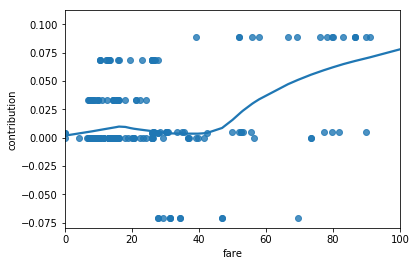

In [23]:
FEATURE = 'fare'
feature = pd.Series(df_dfc[FEATURE].values, index=dfeval[FEATURE].values).sort_index()
ax = sns.regplot(feature.index.values, feature.values, lowess=True);
ax.set_ylabel('contribution')
ax.set_xlabel(FEATURE);
ax.set_xlim(0, 100);